# Imports:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence
import pandas as pd
import scipy

#### Creating the kernel

In [2]:
#the chessLike kernel parallelize the steps
kernel = np.zeros((256,256))
for i in range(256):
    for j in range(256):
        kernel[i,j] = (i + j)%2

# Classes:

In [304]:
class Ising:
    """

    """
    def __init__(self, l: int, t: float) -> None:
        """
        the function to construct ising model object
        E is the energy of model and will be calculated at first
        M is the magnetization and will be calculated at first
        blackKernel is the chessLike matrix starting with 0
        whiteKernel is the chessLike matrix starting with 1

        :param l:the size of the model
        :type l: int
        :param t: the temp of the model
        :type t: float
        """
        self.t = t
        self.x = np.array(2*(np.round(np.random.uniform(0,1,(l,l))))-1,dtype="int8")
        self.l = l
        self.E = self.getE()
        self.M = self.getM()
        self.blackKernel = kernel[:l,:l]
        self.whiteKernel = 1 - self.blackKernel
        self.map = np.zeros((self.l,self.l))

        #initializing the ising model object for 500*l**2 steps
        for _ in range(500):
             self.step()

    def getM(self) -> np.ndarray:
        """
        the function to get the magnetization of the system by summation on all spins

        :return: the magnetization
        :rtype: np.ndarray
        """
        return np.abs(np.sum(self.x))

    def getE(self) -> np.ndarray:
        """
        the function to get the energy of the systems by multiplying every spin with the left and the bellow one,summation and * -1

        Instead of going on each spin and calculating,
        i generated the sifted matrix of the spins and multiplied the sifted matrix to the spin matrix

        :return: the energy of the system
        :rtype: np.ndarray
        """
        leftSided = np.zeros((self.l,self.l))
        downSided = np.zeros((self.l,self.l))

        leftSided[:,0] = self.x[:,-1]
        leftSided[:,1:] = self.x[:,:-1]

        downSided[0,:] = self.x[-1,:]
        downSided[1:,:] = self.x[:-1,:]

        return -np.sum(self.x * (leftSided +downSided))

    def getDeltaE(self) -> np.ndarray:
        """
        the function to calculate the dE of changing any spin in ising model by multiplying the left,right,bellow and up,summation and *2

        Instead of going on each spin and calculating,
        i generated the sifted matrix of the spins and multiplied the sifted matrix to the spin matrix

        :return: the dE of changing any spin in ising model
        :rtype: np.ndarray
        """
        leftSided = np.zeros((self.l,self.l))
        rightSided = np.zeros((self.l,self.l))
        downSided = np.zeros((self.l,self.l))
        upSided = np.zeros((self.l,self.l))

        leftSided[:,0] = self.x[:,-1]
        leftSided[:,1:] = self.x[:,:-1]

        rightSided[:,-1] = self.x[:,0]
        rightSided[:,:-1] = self.x[:,1:]

        downSided[0,:] = self.x[-1,:]
        downSided[1:,:] = self.x[:-1,:]

        upSided[-1,:] = self.x[0,:]
        upSided[:-1,:] = self.x[1:,:]

        return 2 *self.x * (leftSided + rightSided + downSided + upSided)

    def step(self) -> None:
        """
        the function to go one step further in simulation

        I parallelized the steps of (l*L) by finding the independent spins(black ones and whites ones) and updating each group
        dEMatrix is the matrix of dE for changing each spin
        conditionMatrix represents if the spins is going to change and is calculated by the metropolis algorithm:
        if dE<0 or random(0,1) < e^(-dE): change!
        then we accept the changing ones
        """
        dEMatrix = self.getDeltaE()
        conditionMatrix = np.logical_or(dEMatrix<0,np.random.rand(self.l,self.l)< np.exp(-dEMatrix/self.t))
        self.accept(conditionMatrix*self.blackKernel , dEMatrix)

        dEMatrix = self.getDeltaE()
        conditionMatrix = np.logical_or(dEMatrix<0,np.random.rand(self.l,self.l)< np.exp(-dEMatrix/self.t))
        self.accept(conditionMatrix * self.whiteKernel , dEMatrix)

    def accept(self, conditionMatrix: np.ndarray, deltaEMatrix: np.ndarray) -> None:
        """
        the function to accept the changes and update the spins,M and E

        to change the M and E we only effect the changing spin and we don't need to calculate the M and E again
        the M changes with - 2 * value of the changing ones.
        the E changes with dE of the changing ones

        :param conditionMatrix: the matrix representing the changing spins
        :type conditionMatrix: np.ndarray
        :param deltaEMatrix: the matrix representing the dE of changing any spin
        :type deltaEMatrix: np.ndarray
        """
        self.E += np.sum(deltaEMatrix * conditionMatrix)
        self.M += -2 * np.sum(self.x * conditionMatrix)
        self.x *= 1 - 2*np.array(conditionMatrix,dtype="int8")


    def run(self, steps: int) -> Sequence:
        """
        the function to run the simulation of ising model for several steps and returning <E> , <|M|> ,X ,C amd correlationLength

        :param steps: the big steps of simulation
        :type steps: int
        :return: the sequence of <E> , <|M|> ,X ,C amd correlationLength
        :rtype: Sequence
        """

        es = np.zeros(steps)
        ms = np.zeros(steps)
        #gathering data during steps
        for i in range(steps):
            es[i] = self.E
            ms[i] = np.abs(self.M)
            self.step()

        # C is the var(<E>)/t^2
        C = np.var(es)/(self.t**2)

        # X is the var(<|M|>)/t
        X = np.var(ms)/self.t

        # Cl is calculated by its special function
        correlationLength = self.correlationLength()

        return np.mean(es) , np.mean(ms) , X , C , correlationLength

    def autoCorrelation(self, array: np.ndarray) -> np.ndarray:
        """
        the function to calculate the auto correlation of input line using Cj = (<xi><xi+j> - <xi>^2)/var(x)
        if vat(x)=0 return zero to avoid division by zero

        :param array: the input line
        :type array: np.ndarray
        :return: the autocorrelation
        :rtype:  np.ndarray
        """
        n = len(array) // 10

        if np.var(array) == 0:
            return np.zeros(n)

        autoCorrelation = np.zeros(n)
        for i in range(n):
            autoCorrelation[i]= (  np.dot(array,np.roll(array,i))/len(array) - np.mean(array)**2) / np.var(array)
        return autoCorrelation

    def correlationLength(self) -> np.ndarray:
        """
        the function to calculate the correlation length of the system by mean of correlationLengths of each line
        the correlationLength of each line is 1 + the len of fitting autoCorrelation of the line into e^-1

        :return:
        :rtype:
        """
        autoCorrelations = np.zeros(self.l)
        for i in range(self.l):
            autoCorrelation = self.autoCorrelation(self.x[i])
            autoCorrelations[i]= len(autoCorrelation[autoCorrelation > np.exp(-1)]) + 1
        return np.mean(autoCorrelations)

    def visualize(self,save=False) -> None:
        """
        the function to visualize the Ising model

        :param save: if the plot is going to be saved as png
        :type save: bool
        """
        plt.figure(figsize=(10,10))
        plt.title("Ising model with l={0} and T={1}".format(self.l,self.t))
        plt.imshow(self.x)

        if save:
            plt.savefig("{}.png".format(self.t))
        else:
            plt.show()

    def doColor(self) -> None:
        self.color = 1
        for i in range(self.l):
            for j in range(self.l):
                self.checkSquare(i,j)

    def checkSquare(self, x: int, y: int) -> None:
        """
        the function to check a square

        :param x:the first coordination of the point
        :type x:int
        :param y:the second coordination of the point
        :type y:int
        """
        if self.map[x,y] == 0:
            self.map[x,y] = self.color
            self.color += 1
            #checkN
            lns = self.getLightingNeighbors(x,y)  #find the neighbors with the same sign
            for neighbor in lns:
                c = self.map[neighbor[0],neighbor[1]]
                if c == 0 :
                    self.map[neighbor[0],neighbor[1]] = self.map[x,y]
                else:
                    self.map += (self.map[x,y]-c)*np.ones((self.l,self.l))*(self.map==c)


        else:
            #checkN
            lns = self.getLightingNeighbors(x,y)  #find the neighbors with the same sign
            if len(lns) > 1:
                for neighbor in lns:
                    c = self.map[neighbor[0],neighbor[1]]
                    if c == 0 :
                        self.map[neighbor[0],neighbor[1]] = self.map[x,y]
                    else:
                        self.map += (self.map[x,y]-c)*np.ones((self.l,self.l))*(self.map==c)

    def getColors(self, points: Sequence[Sequence[int]]) -> Sequence[int]:
        """
        the function to get the colors of the points in the input list

        :param points:the input list
        :type points:Sequence[Sequence[int]]
        :return:the list of colors
        :rtype:Sequence[int]
        """
        colors = []
        for point in points:
            colors.append(self.map[point[0]][point[1]])
        return list(set(colors))


    def getLightingNeighbors(self, x: int, y: int) -> Sequence[Sequence[int]]:
        spin = self.x[x,y]
        lightingNeighbors = []

        if self.x[(x+1)%self.l,y]==spin:
            lightingNeighbors.append(((x+1)%self.l,y))

        if self.x[(x-1)%self.l,y]==spin:
            lightingNeighbors.append(((x-1)%self.l,y))

        if self.x[x,(y+1)%self.l]==spin:
                lightingNeighbors.append((x,(y+1)%self.l))

        if self.x[x,(y-1)%self.l]==spin:
                lightingNeighbors.append((x,(y-1)%self.l))

        return lightingNeighbors


    def getAreas(self):
        self.doColor()
        areas = np.zeros(int(np.max(self.map)),dtype=int)
        for i in range(int(np.max(self.map))+1):
            areas[i-1] = int(np.sum(self.map == i ))

        # delete zeros
        areas = list(areas)
        for zeros in range(areas.count(0)):
            areas.remove(0)
        return areas



#### defining the betas:

In [4]:
betas = np.linspace(0.1,0.8,41) # 41 betas in [0.1,0.8]

## Gathering Data:

In [5]:
def getData(l: int, iterations: int, steps: int) -> Sequence:
    """
    the function to get data of simulation for input size and steps and betas,eventually returning the mean of iterations

    :param l: the size of the model
    :type l:int
    :param iterations:the number of iterations
    :type iterations: int
    :param steps: the steps of simulation in each iteration
    :type steps: int
    :return: the Sequence of mean data in iterations
    :rtype: Sequence
    """
    meanEs = np.zeros(41)
    meanMs = np.zeros(41)
    xs = np.zeros(41)
    cs = np.zeros(41)
    correlationLengths = np.zeros(41)

    # for different betas:
    for i in range(41):
        iterationMeanEs = np.zeros(iterations)
        iterationMeanMs = np.zeros(iterations)
        iterationXs = np.zeros(iterations)
        iterationCs = np.zeros(iterations)
        iterationCorrelationLengths = np.zeros(iterations)

        # for different iterations:
        for j in range(iterations):
            ising = Ising(l,1/betas[i])
            meanE,meanM,x,c,cl = ising.run(steps)
            iterationMeanEs[j] = meanE
            iterationMeanMs[j] = meanM
            iterationXs[j] = x
            iterationCs[j] = c
            iterationCorrelationLengths[j] = cl

        # calculating the mean of different iterations
        meanEs[i] = np.mean(iterationMeanEs)
        meanMs[i] = np.mean(iterationMeanMs)
        xs[i] = np.mean(iterationXs)
        cs[i] = np.mean(iterationCs)
        correlationLengths[i] = np.mean(iterationCorrelationLengths)

    return meanEs,meanMs,xs,cs,correlationLengths

In [49]:
# getting data for l=30:
meanEs30,meanMs30,xs30,cs30,correlationLengths30 = getData(30,100,100)

In [50]:
df30 = pd.DataFrame({"meansEs":meanEs30,"meanMs":meanMs30,"xs":xs30,"cs":cs30,"correlationLengths":correlationLengths30})
df30.to_csv("df30.csv")

In [51]:
# getting data for l=40:
meanEs40,meanMs40,xs40,cs40,correlationLengths40 = getData(40,100,100)

In [52]:
df40 = pd.DataFrame({"meansEs":meanEs40,"meanMs":meanMs40,"xs":xs40,"cs":cs40,"correlationLengths":correlationLengths40})
df40.to_csv("df40.csv")

In [53]:
# getting data for l=50:
meanEs50,meanMs50,xs50,cs50,correlationLengths50 = getData(50,100,100)

In [54]:
df50 = pd.DataFrame({"meansEs":meanEs50,"meanMs":meanMs50,"xs":xs50,"cs":cs50,"correlationLengths":correlationLengths50})
df50.to_csv("df50.csv")

In [55]:
# getting data for l=60:
meanEs60,meanMs60,xs60,cs60,correlationLengths60 = getData(60,100,100)

In [56]:
df60 = pd.DataFrame({"meansEs":meanEs60,"meanMs":meanMs60,"xs":xs60,"cs":cs60,"correlationLengths":correlationLengths60})
df60.to_csv("df60.csv")

In [57]:
# getting data for l=70:
meanEs70,meanMs70,xs70,cs70,correlationLengths70 = getData(70,100,100)

In [58]:
df70 = pd.DataFrame({"meansEs":meanEs70,"meanMs":meanMs70,"xs":xs70,"cs":cs70,"correlationLengths":correlationLengths70})
df70.to_csv("df70.csv")

In [59]:
# getting data for l=80:
meanEs80,meanMs80,xs80,cs80,correlationLengths80 = getData(80,100,100)

In [60]:
df80 = pd.DataFrame({"meansEs":meanEs80,"meanMs":meanMs80,"xs":xs80,"cs":cs80,"correlationLengths":correlationLengths80})
df80.to_csv("df80.csv")

# Data Analysis:

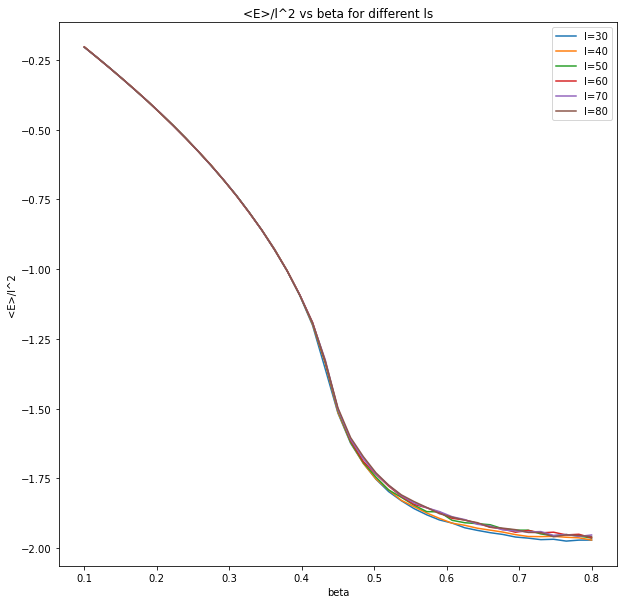

In [61]:
plt.figure(figsize=(10,10))
plt.title("<E>/l^2 vs beta for different ls")
plt.plot(np.linspace(0.1,0.8,41) ,meanEs30/30**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanEs40/40**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanEs50/50**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanEs60/60**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanEs70/70**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanEs80/80**2)

plt.xlabel("beta")
plt.ylabel("<E>/l^2")
plt.legend(["l=30","l=40","l=50","l=60","l=70","l=80"])
plt.show()

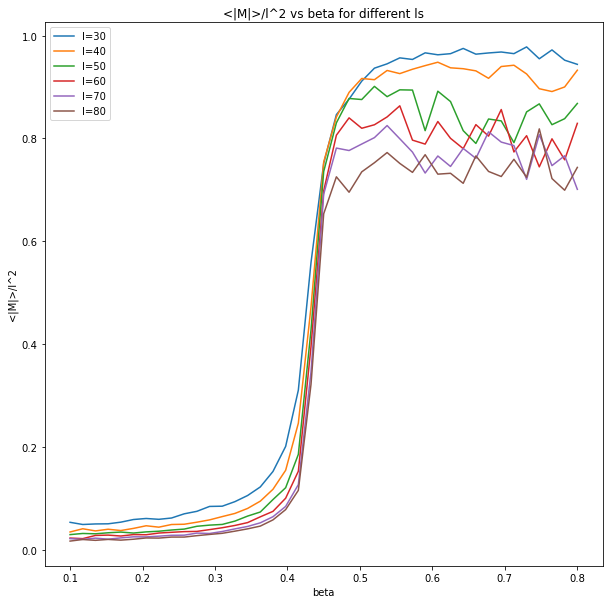

In [62]:
plt.figure(figsize=(10,10))
plt.title("<|M|>/l^2 vs beta for different ls")

plt.plot(np.linspace(0.1,0.8,41) ,meanMs30/30**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanMs40/40**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanMs50/50**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanMs60/60**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanMs70/70**2)
plt.plot(np.linspace(0.1,0.8,41) ,meanMs80/80**2)
plt.xlabel("beta")
plt.ylabel("<|M|>/l^2")
plt.legend(["l=30","l=40","l=50","l=60","l=70","l=80"])
plt.show()

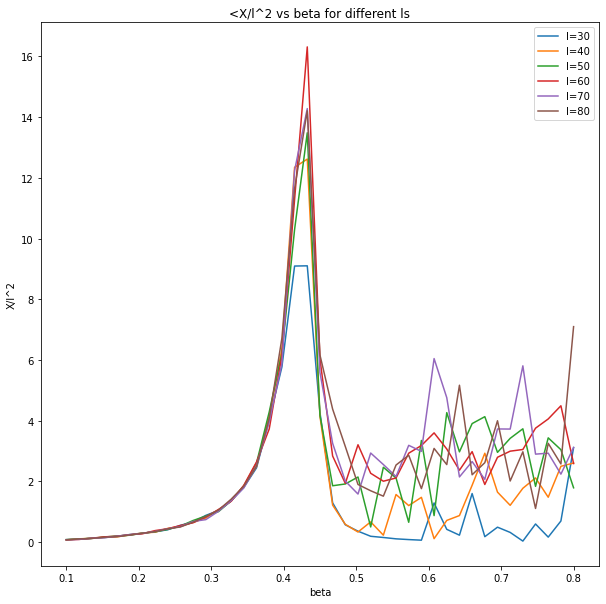

In [63]:
plt.figure(figsize=(10,10))
plt.title("<X/l^2 vs beta for different ls")

plt.plot(np.linspace(0.1,0.8,41) ,xs30/30**2)
plt.plot(np.linspace(0.1,0.8,41) ,xs40/40**2)
plt.plot(np.linspace(0.1,0.8,41) ,xs50/50**2)
plt.plot(np.linspace(0.1,0.8,41) ,xs60/60**2)
plt.plot(np.linspace(0.1,0.8,41) ,xs70/70**2)
plt.plot(np.linspace(0.1,0.8,41) ,xs80/80**2)

plt.xlabel("beta")
plt.ylabel("X/l^2")
plt.legend(["l=30","l=40","l=50","l=60","l=70","l=80"])
plt.show()

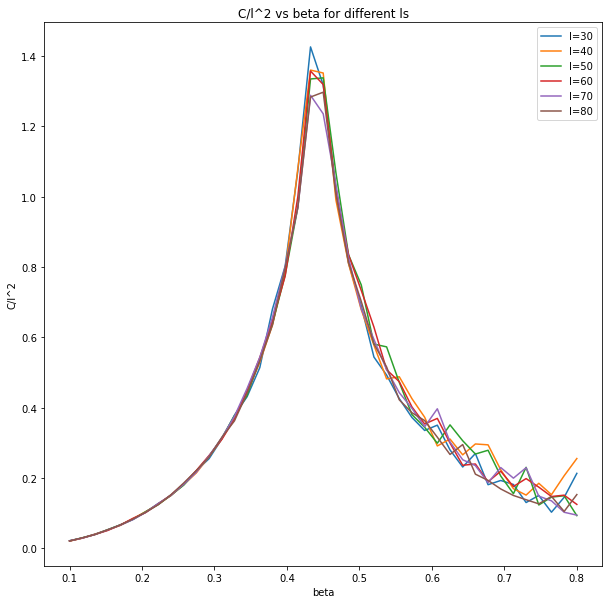

In [64]:
plt.figure(figsize=(10,10))
plt.title("C/l^2 vs beta for different ls")
plt.plot(np.linspace(0.1,0.8,41) ,cs30/30**2)
plt.plot(np.linspace(0.1,0.8,41) ,cs40/40**2)
plt.plot(np.linspace(0.1,0.8,41) ,cs50/50**2)
plt.plot(np.linspace(0.1,0.8,41) ,cs60/60**2)
plt.plot(np.linspace(0.1,0.8,41) ,cs70/70**2)
plt.plot(np.linspace(0.1,0.8,41) ,cs80/80**2)

plt.xlabel("beta")
plt.ylabel("C/l^2")
plt.legend(["l=30","l=40","l=50","l=60","l=70","l=80"])
plt.show()

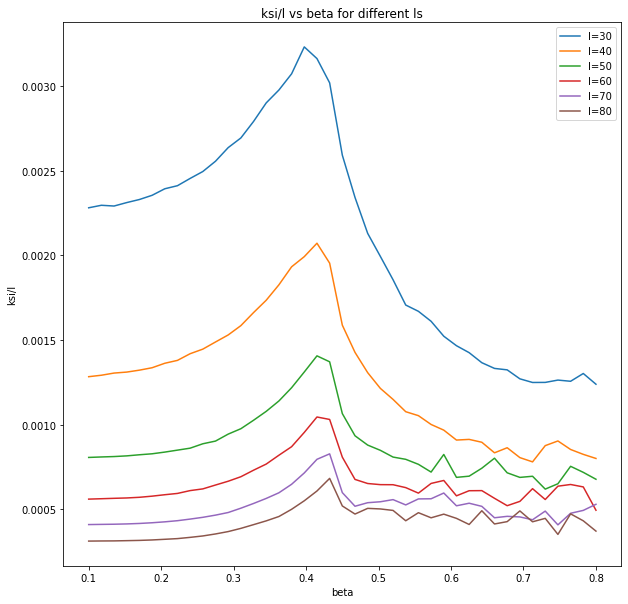

In [65]:
plt.figure(figsize=(10,10))
plt.title("ksi/l vs beta for different ls")

plt.plot(np.linspace(0.1,0.8,41) ,correlationLengths30/30**2)
plt.plot(np.linspace(0.1,0.8,41) ,correlationLengths40/40**2)
plt.plot(np.linspace(0.1,0.8,41) ,correlationLengths50/50**2)
plt.plot(np.linspace(0.1,0.8,41) ,correlationLengths60/60**2)
plt.plot(np.linspace(0.1,0.8,41) ,correlationLengths70/70**2)
plt.plot(np.linspace(0.1,0.8,41) ,correlationLengths80/80**2)

plt.xlabel("beta")
plt.ylabel("ksi/l")
plt.legend(["l=30","l=40","l=50","l=60","l=70","l=80"])
plt.show()

#### fitting curves into the data:

In [181]:
Tc_l_x = [ 1/betas[a.index(max(a))] for a in [list(xs30/30**2),list(xs40/40**2),list(xs50/50**2),list(xs60/60**2),list(xs70/70**2),list(xs80/80**2)]]
Xc_l = [max(a) for a in [xs30/30**2,xs40/40**2,xs50/50**2,xs60/60**2,xs70/70**2,xs80/80**2]]

In [182]:
Tc_l_ksi = [ 1/betas[a.index(max(a))] for a in [list(correlationLengths30/30),list(correlationLengths40/40),list(correlationLengths50/50),list(correlationLengths60/60),list(correlationLengths70/70),list(correlationLengths80/80)]]
ksic_l = [max(a) for a in [correlationLengths30/30,correlationLengths40/40,correlationLengths50/50,correlationLengths60/60,correlationLengths70/70,correlationLengths80/80]]

In [183]:
Tc_l_cv = [ 1/betas[a.index(max(a))] for a in [list(cs30/30**2),list(cs40/40**2),list(cs50/50**2),list(cs60/60**2),list(cs70/70**2),list(cs80/80**2)]]
cvc_l = [max(a) for a in [cs30/30**2,cs40/40**2,cs50/50**2,cs60/60**2,cs70/70**2,cs80/80**2]]

In [184]:
Tc_l_m = [1/betas[list(np.abs(a - np.mean(a))).index(min(np.abs(a - np.mean(a))))] for a in [list(meanMs30/30**2),list(meanMs40/40**2),list(meanMs50/50**2),list(meanMs60/60**2),list(meanMs70/70**2),list(meanMs80/80**2)]]
mc_l = [max(a) for a in [meanMs30/30**2,meanMs40/40**2,meanMs50/50**2,meanMs60/60**2,meanMs70/70**2,meanMs80/80**2]]

In [185]:
#Callables:the curves that we are going to fit
def xCallable(Tc_l ,c,gamma,Tc_inf):
    return np.exp(c - gamma * np.log(np.abs(Tc_l - Tc_inf)))

def ksiCallable(Tc_l,c,nu,Tc_inf):
    return np.exp(c - nu * np.log(np.abs(Tc_l - Tc_inf)))

def cvCallable(Tc_l,c,Tc_inf):
    return c * np.log(np.abs(Tc_l - Tc_inf))

def mCallable(Tc_l,c,beta,Tc_inf):
    return np.exp(c + beta * np.log(np.abs(Tc_l - Tc_inf)))

#### fitting:

In [186]:
x_popt = scipy.optimize.curve_fit(xCallable,Tc_l_x,Xc_l,bounds=([-100,0,2],[100,2,3]))

In [187]:
ksi_popt = scipy.optimize.curve_fit(ksiCallable,Tc_l_ksi,ksic_l,maxfev=100000,bounds=([-100,0,2],[100,1,3]))

In [188]:
cv_popt = scipy.optimize.curve_fit(cvCallable,Tc_l_cv,cvc_l,bounds=([-1,2],[0,3]))

In [189]:
m_popt = scipy.optimize.curve_fit(mCallable,Tc_l_m,mc_l,bounds=([-100,0,2],[100,1,3]))

## Results:

In [190]:
print("gamma = ",x_popt[0][1]," with T_c(inf) = ",x_popt[0][2])

gamma =  1.0105822224604004  with T_c(inf) =  2.488858126508669


In [191]:
print("nu = ",ksi_popt[0][1]," with T_c(inf) = ",ksi_popt[0][2])

nu =  0.30062496709598313  with T_c(inf) =  2.4869660574075576


In [192]:
print("c0 = ",cv_popt[0][0]," with T_c(inf) = ",cv_popt[0][1])

c0 =  -0.999999999999999  with T_c(inf) =  2.5508899702204637


In [193]:
print("beta = ",m_popt[0][1]," with T_c(inf) = ",m_popt[0][2])

beta =  0.4964822329851733  with T_c(inf) =  2.5035177670212


## Bonus:

In [371]:
def getHist(l,beta,iterations):
    areas = []
    for i in range(iterations):
        ising = Ising(l,1/beta)
        ising.doColor()
        areas += ising.getAreas()
        print( ising.getAreas())

    counts = np.zeros(max(areas))
    for area in range(1,max(areas)+1):
        counts[area -1] = areas.count(area)


    return counts/iterations,np.arange(1,max(areas)+1)



0.1


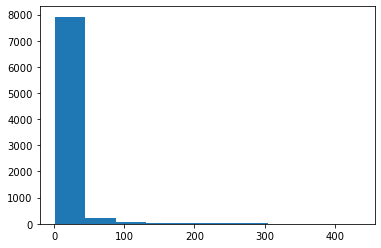

0.11750000000000001


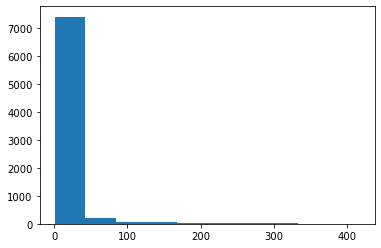

0.135


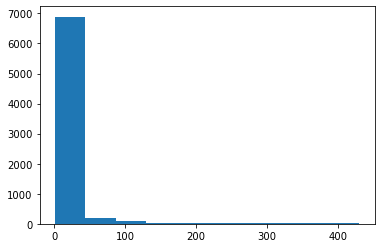

0.15250000000000002


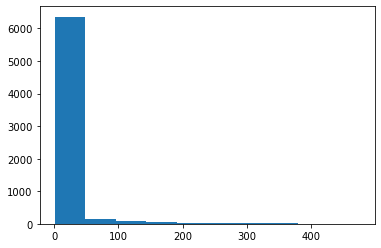

0.17


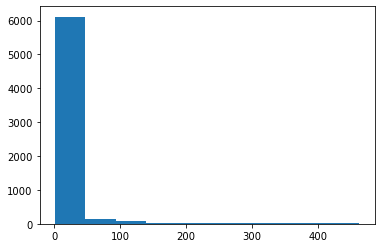

0.1875


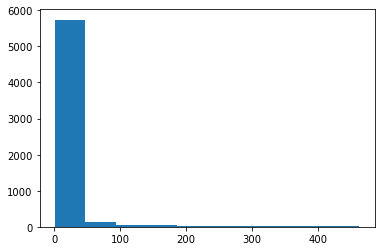

0.20500000000000002


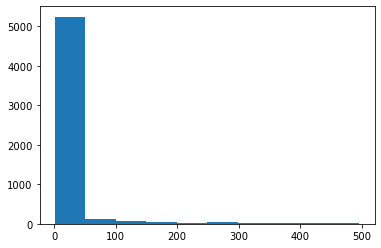

0.22250000000000003


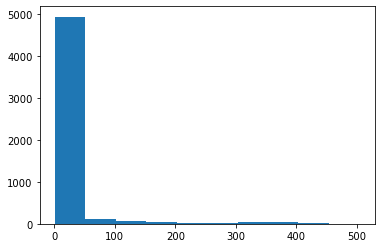

0.24000000000000002


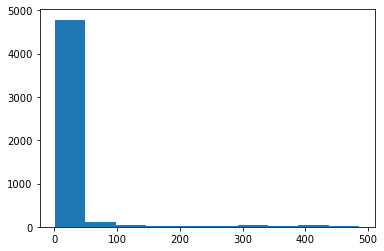

0.25750000000000006


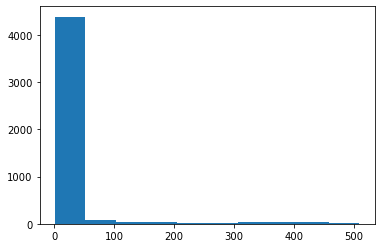

0.275


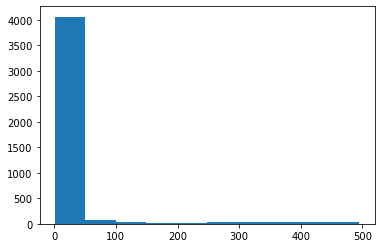

0.2925


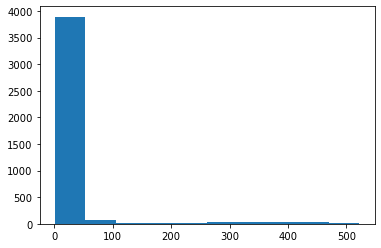

0.31000000000000005


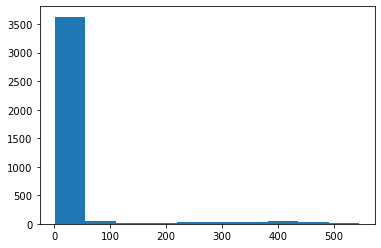

0.3275


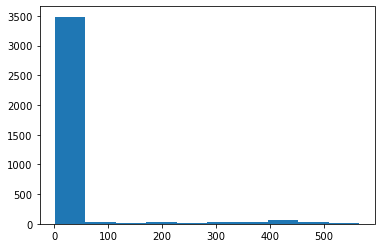

0.34500000000000003


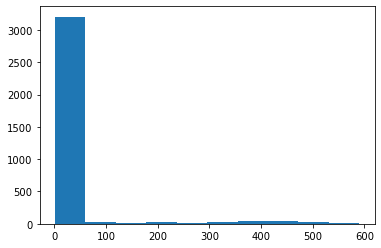

0.36250000000000004


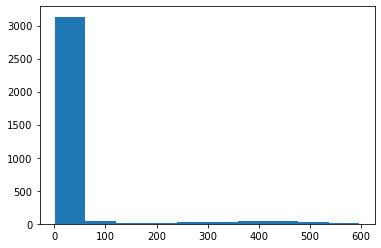

0.38


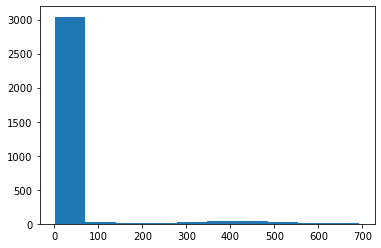

0.3975000000000001


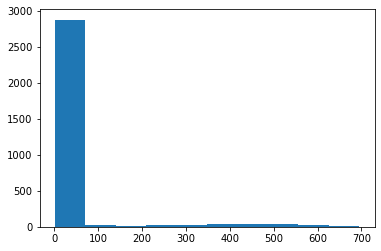

0.41500000000000004


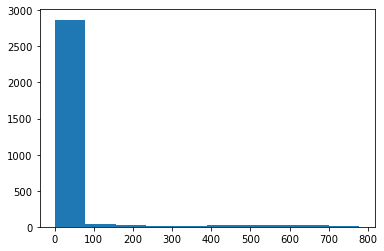

0.4325


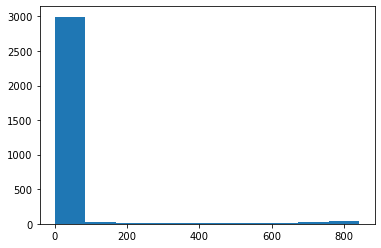

0.45000000000000007


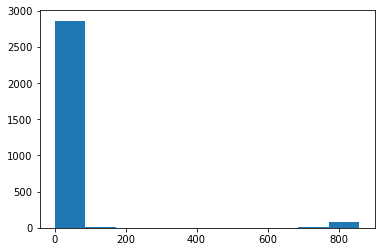

0.4675


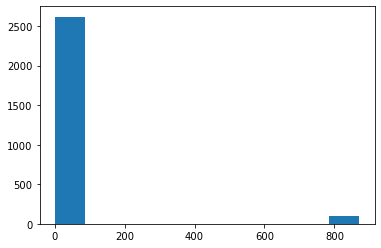

0.485


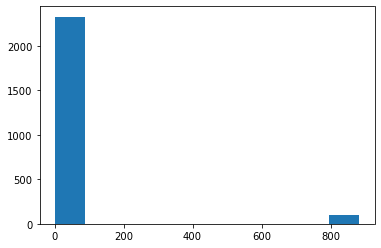

0.5025000000000001


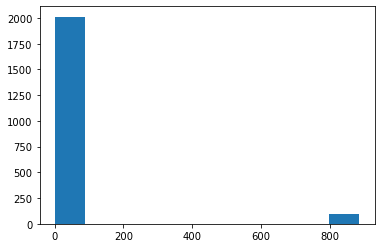

0.52


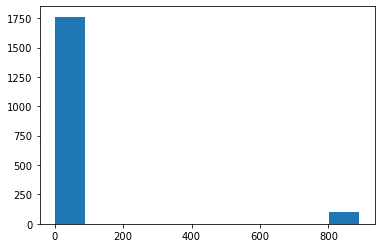

0.5375000000000001


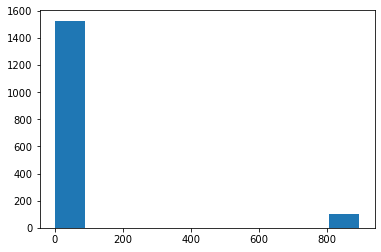

0.555


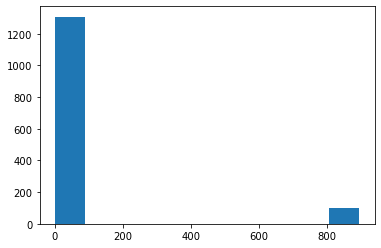

0.5725


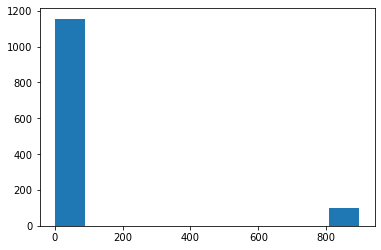

0.5900000000000001


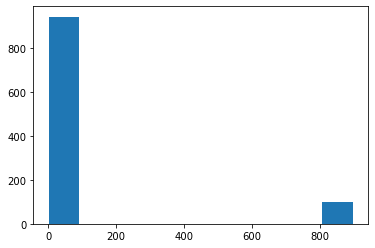

0.6075


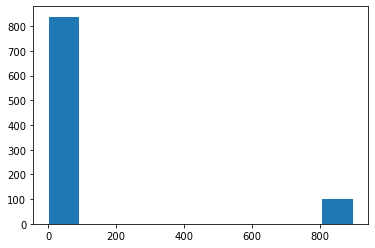

0.625


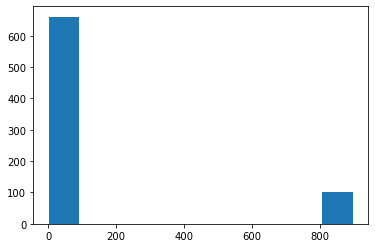

0.6425000000000001


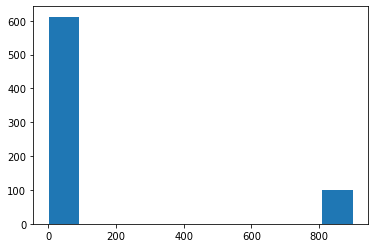

0.66


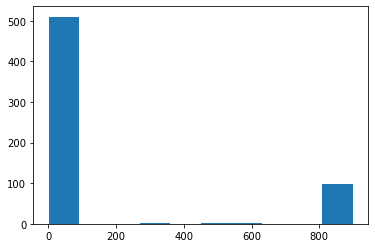

0.6775


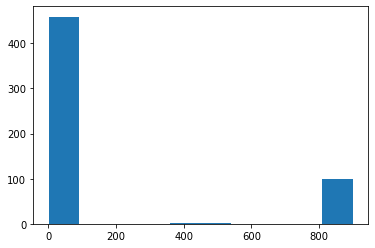

0.6950000000000001


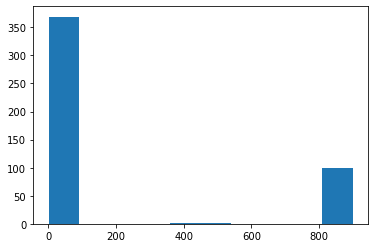

0.7125


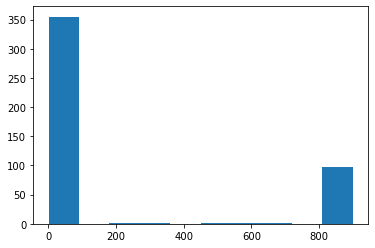

0.7300000000000001


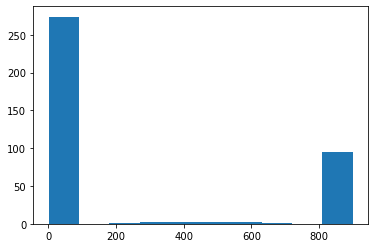

0.7475


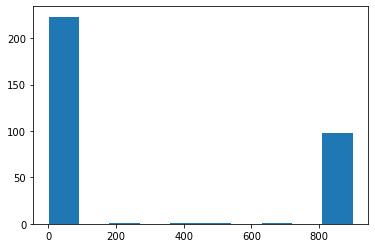

0.765


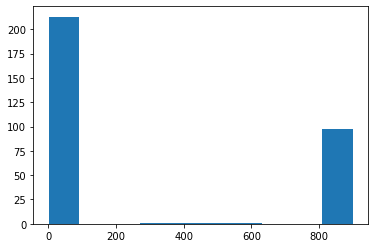

0.7825000000000001


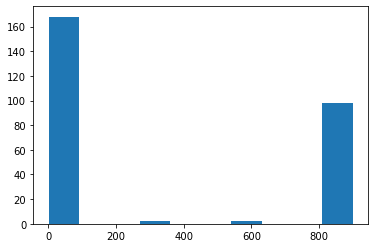

0.8


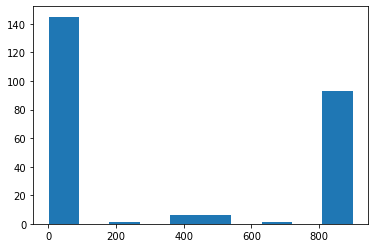

In [380]:
for beta in betas:
    areas = []
    print(beta)
    for i in range(100):

        ising = Ising(30,1/beta)
        ising.doColor()
        areas += ising.getAreas()

    plt.hist(areas)
    plt.show()


when temp. is high we have a lot of small clusters. as temp decreases clusters starts to get bigger and bigger.
as we reach the critical interval the clusters start to eat each other an we giant clusters appear
after we passed through critical interval we only have giant clusters.